Task Website: https://sites.google.com/view/simpletext-sota/home
Competition: https://codalab.lisn.upsaclay.fr/competitions/16616

Dataset: https://github.com/jd-coderepos/sota/tree/master



In [1]:
NOT_FOUND = "unanswerable\n"
TRAIN_PATH = "./data/train"

In [2]:

import os
import json

TRAIN_PATH = "./data/train"


def path_join(*args):
    return os.path.join(*args).replace('\\', '/') 

def find(extension, *args):
    p = path_join(*args)
    res = list(filter(lambda x: x.endswith(extension), os.listdir(p)))
    if res:
        return path_join(p, res[0])
    else:
        return None

all_paths = [(p, find("tex", TRAIN_PATH, p), find("json", TRAIN_PATH, p)) for p in os.listdir(TRAIN_PATH)]

def read(i):
    # print(i)
    tex = None
    jsn = None
    try:
        i, tex_path, jsn_path = all_paths[i]
    except Exception as ex:
        print(i)
        raise ex
    try:
        with open(tex_path) as f:
            tex = f.read()

        try:
            with open(jsn_path) as f:
                jsn = json.load(f)
                print("loaded json")
        except:
            with open(jsn_path) as f:
                jsn = f.read()
                jsn = eval(jsn)
        return i, tex, jsn
    except:
        return i, tex, jsn

In [3]:
import pandas as pd

n = len(all_paths)
data = []
for i, t, j in [read(i) for i in range(n)]:
    # if j and j != 'unanswerable\n':
    data.append((i, t, j))



In [4]:
df_raw = pd.DataFrame(data)
df_raw = df_raw.rename({0: "id", 1: "tex", 2: "jsn"}, axis=1)
df_raw

,id,tex,jsn
0,0704.1707,\documentclass{llncs}\n\usepackage{url}\n\usep...,unanswerable\n
1,0704.2295,\documentclass{llncs}\n\usepackage{graphicx}\n...,unanswerable\n
2,0704.3238,\documentclass{article} \n\RequirePackage{amsf...,unanswerable\n
3,0705.0599,\n\documentclass[a4paper]{article}\n\n\n\usepa...,unanswerable\n
4,0705.0742,"\documentclass[pre,12pt,aps]{revtex4}\n\usepac...",unanswerable\n
...,...,...,...
12283,2312.02139v1,\section{Results}\n\label{sec:results}\n\n\sub...,"[{'LEADERBOARD': {'Task': 'Image Generation', ..."
12284,2312.02185v1,\documentclass[conference]{IEEEtran}\n\IEEEove...,[{'LEADERBOARD': {'Task': 'Human Activity Reco...
12285,2312.03288v1,\documentclass{bmvc2k}\n\usepackage{times}\n\u...,[{'LEADERBOARD': {'Task': 'Skeleton Based Acti...
12286,2312.03430v1,"\n\n\documentclass[10pt,twocolumn,letterpaper]...",[{'LEADERBOARD': {'Task': 'Semantic Segmentati...


In [5]:
# is "id" unique?

total_ids = len(df_raw["id"])
nonduplicate_ids = len(df_raw["id"].drop_duplicates())
print(total_ids)
print(nonduplicate_ids)
# -> yes

12288
12288


# How many are Null / Unanswerable?

In [6]:
df = df_raw


df["isUnanswerable"] = df["jsn"] == NOT_FOUND
df["isNone"] = df["jsn"].isnull()

print(f"total len: {len(df)}")
print(f"None: {len(df[df['isNone']])}")
print(f"Unanswerable: {len(df[df['isUnanswerable']])}")



total len: 12288
None: 882
Unanswerable: 4204


# Leaderboard details

In [7]:
df["numLeaderboards"] = df["jsn"].apply(lambda c: len(c) if c and c != NOT_FOUND else 0)
df["hasLeaderboards"] = df["numLeaderboards"] > 0

print(f"= 0: {len(df[df['numLeaderboards'] == 0])}")
print(f"> 0: {len(df[df['numLeaderboards'] > 0])}")
print(f"> 5: {len(df[df['numLeaderboards'] > 5])}")
print(f"> 10: {len(df[df['numLeaderboards'] > 10])}")
print(f"> 40: {len(df[df['numLeaderboards'] > 40])}")
print(f"> 100: {len(df[df['numLeaderboards'] > 100])}")
print(f"> 200: {len(df[df['numLeaderboards'] > 200])}")

df_lt40 = df[df["numLeaderboards"] < 40]

= 0: 5086
> 0: 7202
> 5: 2647
> 10: 1169
> 40: 103
> 100: 11
> 200: 0


In [8]:
pct_hasLeaderboard =  len(df[df["hasLeaderboards"] == False]) / len(df[df["hasLeaderboards"] == True])
pct_hasLeaderboard

0.7061927242432657

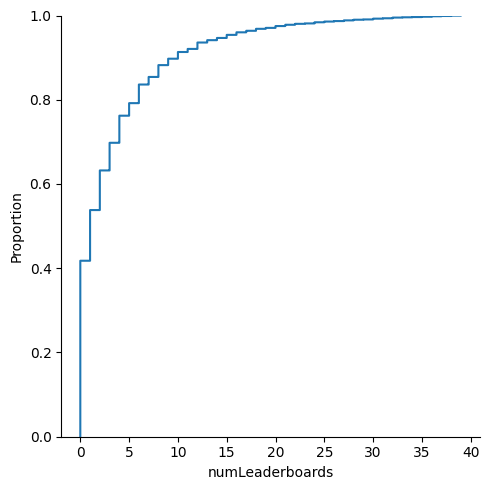

In [9]:
import seaborn as sns

sns.displot(df_lt40["numLeaderboards"], kind="ecdf")

<Axes: xlabel='numLeaderboards', ylabel='Count'>

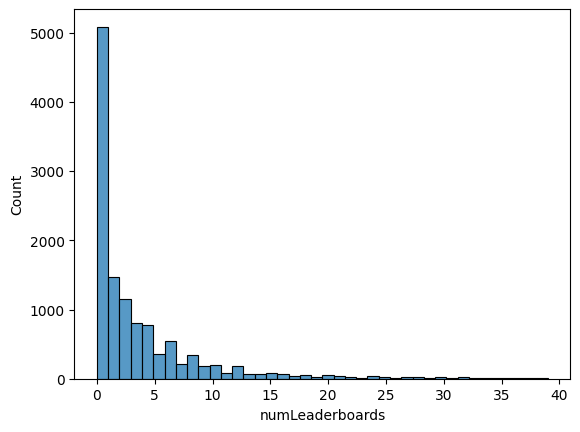

In [10]:
sns.histplot(df_lt40["numLeaderboards"], bins=40)

In [11]:
# Split dataframes into paper & leaderboard entries

df_entries = df[["id", "jsn"]]

df_entries = df_entries.explode("jsn")

df_entries["jsn"] = df_entries["jsn"].apply(lambda c: None if not c or c == NOT_FOUND else c["LEADERBOARD"])
df_entries = df_entries.dropna()

df_entries = pd.concat([df_entries, df_entries["jsn"].apply(pd.Series)], axis=1)
df_entries

,id,jsn,Task,Dataset,Metric,Score
67,0710.3742v1,"{'Task': 'Change Point Detection', 'Dataset': ...",Change Point Detection,TSSB,Relative Change Point Distance,0.20066
67,0710.3742v1,"{'Task': 'Change Point Detection', 'Dataset': ...",Change Point Detection,TSSB,Covering,0.4488
177,0806.3286v2,"{'Task': 'Causal Inference', 'Dataset': 'Jobs'...",Causal Inference,Jobs,Average Treatment Effect on the Treated Error,0.08
1215,1202.2745v1,"{'Task': 'Image Classification', 'Dataset': 'C...",Image Classification,CIFAR-10,Percentage correct,88.8
1215,1202.2745v1,"{'Task': 'Image Classification', 'Dataset': 'M...",Image Classification,MNIST,Percentage error,0.23
...,...,...,...,...,...,...
12286,2312.03430v1,"{'Task': 'Semantic Segmentation', 'Dataset': '...",Semantic Segmentation,UPLight,mIoU,92.45
12286,2312.03430v1,"{'Task': 'Semantic Segmentation', 'Dataset': '...",Semantic Segmentation,MCubeS (P),mIoU,50.99
12286,2312.03430v1,"{'Task': 'Semantic Segmentation', 'Dataset': '...",Semantic Segmentation,MCubeS (P),mIoU,50.55
12286,2312.03430v1,"{'Task': 'Semantic Segmentation', 'Dataset': '...",Semantic Segmentation,MCubeS (P),mIoU,50.34


In [12]:
# Tasks
tasks = df_entries.groupby("Task").count()["id"].sort_values(ascending=False)
print(len(tasks))

# Top 20
tasks[:20]

1213


Task
Image Classification                         2188
Atari Games                                  1243
Object Detection                              946
Video Retrieval                               932
Semi-Supervised Video Object Segmentation     887
Link Prediction                               875
Semantic Segmentation                         856
Node Classification                           840
3D Human Pose Estimation                      830
Question Answering                            676
Image Super-Resolution                        594
Person Re-Identification                      525
Neural Architecture Search                    488
Image Generation                              476
Video Super-Resolution                        462
Node Property Prediction                      446
Monocular Depth Estimation                    439
Anomaly Detection                             409
Few-Shot Semantic Segmentation                382
Image Clustering                             

In [13]:
# Dataset
dataset = df_entries.groupby("Dataset").count()["id"].sort_values(ascending=False)
print(len(dataset))

# Top 20
dataset[:20]

4454


Dataset
ImageNet                                      1540
COCO test-dev                                  766
Human3.6M                                      578
CIFAR-10                                       561
COCO minival                                   298
YouTube-VOS 2018                               295
CIFAR-100                                      238
MSR-VTT-1kA                                    228
FB15k-237                                      225
MSU Super-Resolution for Video Compression     225
DAVIS 2017 (val)                               222
ChEBI-20                                       220
DAVIS 2016                                     206
WN18RR                                         198
3DPW                                           189
Kinetics-400                                   188
MPI-INF-3DHP                                   178
Market-1501                                    176
COCO                                           176
ogbn-arxiv             

In [14]:
# Metric
metric = df_entries.groupby("Metric").count()["id"].sort_values(ascending=False)
print(len(metric))

# Top 20
metric[:20]

2669


Metric
Accuracy              3545
Score                 1300
F1                    1257
PSNR                  1077
mAP                    787
mIoU                   778
SSIM                   750
Top 1 Accuracy         741
Number of params       684
FID                    574
AP                     519
Mean IoU               518
MAE                    493
1:1 Accuracy           457
AUC                    409
Top-1 Accuracy         388
Percentage correct     335
Rank-1                 312
Accuracy (%)           305
MRR                    296
Name: id, dtype: int64

# Which entries can be found in the text?

In [15]:
def is_in_tex(item, tex):
    return item in tex

In [16]:
df_combined = df_entries.merge(df[["id", "tex"]],on="id")
df_combined["Task_found"] = df_combined.apply(lambda row: row["Task"] in row["tex"], axis=1)
df_combined["Dataset_found"] = df_combined.apply(lambda row: row["Dataset"] in row["tex"], axis=1)
df_combined["Metric_found"] = df_combined.apply(lambda row: row["Metric"] in row["tex"], axis=1)

In [17]:
tot = len(df_combined)
t_found = len(df_combined[df_combined['Task_found']])
ds_found = len(df_combined[df_combined['Dataset_found']])
metric_found = len(df_combined[df_combined['Metric_found']])
print(f"total TDMS: {len(df_combined)}")
print(f"Task found: {t_found} -> {t_found/tot}")
print(f"Dataset found: {ds_found} -> {ds_found/tot}")
print(f"Metric found: {metric_found} -> {metric_found/tot}")

total TDMS: 48920
Task found: 18380 -> 0.3757154538021259
Dataset found: 22869 -> 0.467477514309076
Metric found: 18264 -> 0.3733442354865086


In [18]:
df_combined

,id,jsn,Task,Dataset,Metric,Score,tex,Task_found,Dataset_found,Metric_found
0,0710.3742v1,"{'Task': 'Change Point Detection', 'Dataset': ...",Change Point Detection,TSSB,Relative Change Point Distance,0.20066,\documentclass[]{article}\n\usepackage{proceed...,False,False,False
1,0710.3742v1,"{'Task': 'Change Point Detection', 'Dataset': ...",Change Point Detection,TSSB,Covering,0.4488,\documentclass[]{article}\n\usepackage{proceed...,False,False,False
2,0806.3286v2,"{'Task': 'Causal Inference', 'Dataset': 'Jobs'...",Causal Inference,Jobs,Average Treatment Effect on the Treated Error,0.08,"\n\documentclass[aoas,nameyear,dvips]{arximspd...",False,False,False
3,1202.2745v1,"{'Task': 'Image Classification', 'Dataset': 'C...",Image Classification,CIFAR-10,Percentage correct,88.8,\documentclass[a4paper]{article}\n\usepackage{...,True,False,False
4,1202.2745v1,"{'Task': 'Image Classification', 'Dataset': 'M...",Image Classification,MNIST,Percentage error,0.23,\documentclass[a4paper]{article}\n\usepackage{...,True,True,False
...,...,...,...,...,...,...,...,...,...,...
48915,2312.03430v1,"{'Task': 'Semantic Segmentation', 'Dataset': '...",Semantic Segmentation,UPLight,mIoU,92.45,"\n\n\documentclass[10pt,twocolumn,letterpaper]...",True,True,True
48916,2312.03430v1,"{'Task': 'Semantic Segmentation', 'Dataset': '...",Semantic Segmentation,MCubeS (P),mIoU,50.99,"\n\n\documentclass[10pt,twocolumn,letterpaper]...",True,False,True
48917,2312.03430v1,"{'Task': 'Semantic Segmentation', 'Dataset': '...",Semantic Segmentation,MCubeS (P),mIoU,50.55,"\n\n\documentclass[10pt,twocolumn,letterpaper]...",True,False,True
48918,2312.03430v1,"{'Task': 'Semantic Segmentation', 'Dataset': '...",Semantic Segmentation,MCubeS (P),mIoU,50.34,"\n\n\documentclass[10pt,twocolumn,letterpaper]...",True,False,True
